# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import skvideo.io

## Подготовка датасета для классификации

In [2]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './data'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [3]:
len(dataset)

599

In [4]:
SUBSET_LEN = 400
TEST_SIZE = 0.3
test_subset_len = int(SUBSET_LEN * TEST_SIZE) 
random.shuffle(dataset)
train_data = dataset[:SUBSET_LEN]
test_data = dataset[SUBSET_LEN:(SUBSET_LEN + test_subset_len)]
print('train_Dataset samples (subset):', len(train_data))
print('test_Dataset samples (subset):', len(test_data))

train_Dataset samples (subset): 400
test_Dataset samples (subset): 120


In [5]:
from tensorflow.keras.utils import Sequence
import cv2

Колаборатория доблесно отказалась предоставлять ресурсы, поэтому пришлось уменьшить размер видео, что бы получить батчи влезающие в опреративку. Тут кастомный датасет, который это делает.

In [6]:
class KTHDataset(Sequence):
  def __init__(self, dataset, batch_size, new_vid_res=(60,80)):
    self.dataset = dataset
    self.batch_size = batch_size
    self.new_vid_res = new_vid_res

  def __len__(self):
    return len(self.dataset) // self.batch_size

  def __getitem__(self, idx):
    batch = self.dataset[(idx * self.batch_size):((idx+1) * self.batch_size)]
    xs, ys = [], []
    for iter, (fpath, label) in enumerate(batch):
          videodata = skvideo.io.vread(fpath)
          videodata = videodata.astype(np.float32) / 255.
          videodata = self._resize_video(videodata, self.new_vid_res)
          motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)       
          xs.append(motion)
          ys.append(np.array(label))
    xs = self._make_video_same_long(xs)
    if len(xs) > 1:
      x_batch = np.concatenate(xs, axis=0)
      y_batch = np.array(ys)
      return x_batch, y_batch
    else:
      return xs[0], np.array([ys[0]])

  def on_epoch_end(self):
    random.shuffle(self.dataset)

  def _make_video_same_long(self, list_of_vids):
    lengths = []
    for vid in list_of_vids:
      lengths.append(vid.shape[0])
    shortest_vid_long = min(lengths)
    return [vid[None, :shortest_vid_long, ...] for vid in list_of_vids]

  def _resize_video(self, videodata, new_vid_res):
    new_vid= []
    for frame in videodata:
      new_vid.append(cv2.resize(frame, new_vid_res))
    return np.array(new_vid)
    
    


In [7]:
NEW_RESOLUTION = (80,60)
BATCH_SIZE = 2

train_dataset = KTHDataset(train_data, batch_size=BATCH_SIZE, new_vid_res=NEW_RESOLUTION)
test_dataset = KTHDataset(test_data, batch_size=BATCH_SIZE, new_vid_res=NEW_RESOLUTION)

In [8]:
for i in train_dataset:
    a = i[0]
    break

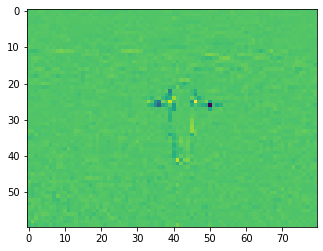

In [9]:
plt.imshow(a[0][25])

## Визуализация кадра из видео

videodata shape: (285, 120, 160, 3)


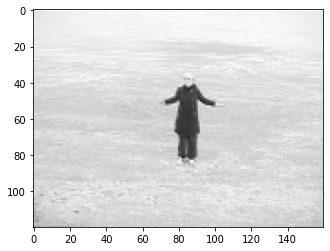

In [10]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[25, ...])

## Визуализация "движения"

motion shape: (284, 120, 160, 1)


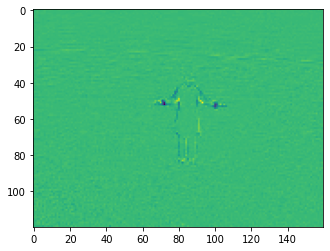

In [11]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[25, ..., 0])

## Создание модели CNN

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(16, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv3D(16, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(32, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv3D(32, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])

In [13]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
#     tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
#     tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
#     tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
#     tf.keras.layers.GlobalAveragePooling3D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(6, activation=None),
# ])

In [14]:
inp = a[0][None,...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 284, 60, 80, 1)
Output shape: (1, 6)


## Подготовка к обучению

Собираем модельку, почему такую, без понятия - захотелось(других причин реально нету =(()

In [15]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.0003

# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#     optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
#     metrics=['accuracy'])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (1, 284, 60, 80, 16)      448       
_________________________________________________________________
conv3d_1 (Conv3D)            (1, 284, 60, 80, 16)      6928      
_________________________________________________________________
batch_normalization (BatchNo (1, 284, 60, 80, 16)      64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (1, 142, 30, 40, 16)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (1, 142, 30, 40, 32)      13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (1, 142, 30, 40, 32)      27680     
_________________________________________________________________
batch_normalization_1 (Batch (1, 142, 30, 40, 32)      1

In [16]:
%%time
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=NUM_EPOCHS
    )

Epoch 1/10
200/200 [==============================] - 575s 3s/step - loss: 1.6938 - accuracy: 0.2650 - val_loss: 1.9374 - val_accuracy: 0.1250
Epoch 2/10
200/200 [==============================] - 314s 2s/step - loss: 1.5197 - accuracy: 0.3425 - val_loss: 1.7265 - val_accuracy: 0.1667
Epoch 3/10
200/200 [==============================] - 256s 1s/step - loss: 1.3153 - accuracy: 0.4175 - val_loss: 1.4494 - val_accuracy: 0.2083
Epoch 4/10
200/200 [==============================] - 265s 1s/step - loss: 1.2195 - accuracy: 0.4200 - val_loss: 1.1909 - val_accuracy: 0.4583
Epoch 5/10
200/200 [==============================] - 244s 1s/step - loss: 1.0922 - accuracy: 0.5225 - val_loss: 0.9122 - val_accuracy: 0.5750
Epoch 6/10
200/200 [==============================] - 234s 1s/step - loss: 1.0360 - accuracy: 0.5650 - val_loss: 1.1456 - val_accuracy: 0.6500
Epoch 7/10
200/200 [==============================] - 215s 1s/step - loss: 0.9317 - accuracy: 0.6325 - val_loss: 1.7071 - val_accuracy: 0.3750

## Тестирование обученной модели

In [20]:
iterator = iter(test_dataset)

In [21]:
vid, label = next(iterator)

True class: boxing
Predicted class: boxing


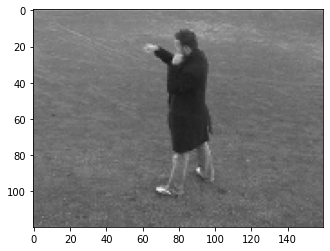

In [29]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

У меня после всех курсов не появилось никакого понимания, какие слои CNN нужно выстраивать в зависимости от входящей информации. Показали очень много архитектур, но реального сравнения не было ни разу. Почему конртно тут автор решил что 4 слоя нужно, почему нету двойных, почему ядра именно этого размера, почему такие страйды. И я честно говоря не нашел даже статей по этому поводу. Все статьи - это а давайте сравним 10 сеток стейт оф арт. Которые различаются кардинально. Почему никто не рассматривает варианты похожие? но точно хуже, что бы было понятно, что это точно не нужно делать. 